In [1]:
import numpy as np
import pandas as pd

In [2]:
test = %run 03准备一个更好的训练集.ipynb

train accuracy: 0.834671
test accuracy: 0.820896


In [6]:
# 和09中的一样，就是多了计算负例率和KS值的代码
def GainTable(y_true_int, y_pred_prob):
    '''Calculate the decile income statement
    Parameters
    ————————————
    y_true_int: True values, where positive examples are 1 and negative examples are 0
    y_pred_prob: Predicted probability of positive examples

    Return value
    ————————————
    out: DataFrame, decile table
    '''
    data = pd.DataFrame({'y_true' : y_true_int, 'prob' : y_pred_prob})
    data['prob'] = 1 - data['prob']
    # Calculate deciles
    data['percentile_gp'] = pd.qcut(data['prob'], q = 10, labels = range(10))
    # Grouped by deciles
    deciles = data.groupby('percentile_gp', sort = True)
    # Define a function to calculate the total number of positive examples
    def total_count(x): return len(x)
    # Define a function to calculate the number of positive examples
    def pos_count(x): return np.sum(x)
    # Define a function to calculate the positive interest rate
    def pos_rate(x): return np.sum(x) / float(len(x))
    # 注意这里out对象的数据是根据十分位整理的统计结果，上面函数的x参数就是每分位传入的x数量（调用十次）
    # 也就是说打印出来应该就是十行分组，out就是每组里数标签的结果，这样看接下来的代码就会清晰很多
    out = deciles['y_true'].agg([total_count, pos_count, pos_rate])
    # Calculate the number of negative examples
    out['neg_count'] = out['total_count'] - out['pos_count']
    # Calculate the cumulative number of positive cases
    # 代码解释：cumsum()用来计算前几组分别累计的命中的正例数，[-1]取最后一个也就是总正例数了
    out['pos_cumsum'] = out['pos_count'].cumsum()
    total_pos = out['pos_cumsum'].iloc[-1]
    # 负例数
    out['neg_cumsum'] = out['neg_count'].cumsum()
    total_neg = out['neg_cumsum'].iloc[-1]
    # Calculate the coverage rate of positive examples
    out['pos_cover_rate'] = out['pos_cumsum'] / float(total_pos)
    # Calculate the coverage rate of negative examples
    out['neg_cover_rate'] = out['neg_cumsum'] / float(total_neg)
    # Regenerate a tag column
    out['percentile'] = (out.index.astype(int) + 1) / 10.0
    # KS
    out['ks'] = np.abs(out['pos_cover_rate'] - out['neg_cover_rate'])
    return out[['percentile', 'total_count', 'pos_count', 'neg_count', 'pos_rate', 'pos_cover_rate','neg_cover_rate', 'ks']]

In [7]:
y_train_prob = lr.predict_proba(X_train)
y_pred_prob = y_train_prob[:, 1]
y_train = list(y_train)

y_pred_prob[:10]
y_train[:10]

array([0.92047738, 0.09742242, 0.60720086, 0.07249371, 0.10562275,
       0.42023458, 0.85710159, 0.0975207 , 0.09768024, 0.24583571])

[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]

In [8]:
gain_table = GainTable(y_train, y_pred_prob)
gain_table

,percentile,total_count,pos_count,neg_count,pos_rate,pos_cover_rate,neg_cover_rate,ks
percentile_gp,,,,,,,,
0,0.1,63,61.0,2.0,0.968254,0.264069,0.005102,0.258967
1,0.2,62,58.0,4.0,0.935484,0.515152,0.015306,0.499845
2,0.3,62,37.0,25.0,0.596774,0.675325,0.079082,0.596243
3,0.4,62,23.0,39.0,0.370968,0.774892,0.178571,0.596320
4,0.5,69,14.0,55.0,0.202899,0.835498,0.318878,0.516620
5,0.6,56,8.0,48.0,0.142857,0.870130,0.441327,0.428803
6,0.7,70,10.0,60.0,0.142857,0.913420,0.594388,0.319032
7,0.8,55,9.0,46.0,0.163636,0.952381,0.711735,0.240646
8,0.9,61,7.0,54.0,0.114754,0.982684,0.849490,0.133194


Text(0.5, 0, 'Percentile')

Text(0, 0.5, 'Cover rate')

Text(0, 0.5, 'KS value')

(0.0, 100.0)

Text(0.5, 1.0, 'KS')

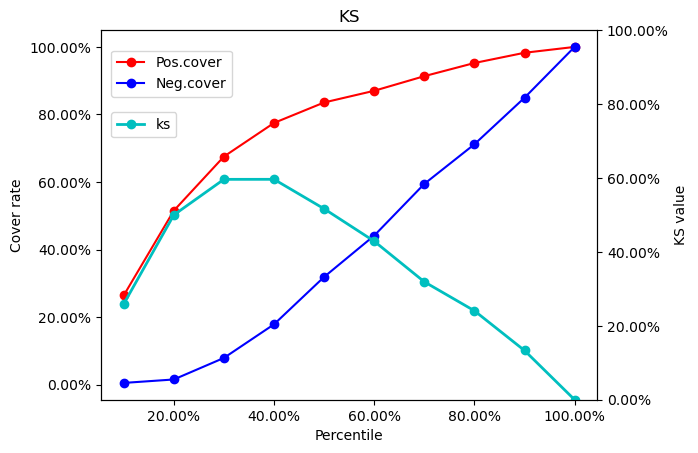

In [11]:
from matplotlib import ticker as mtick
fig, ax1 = plt.subplots()
# 主坐标轴上绘制覆盖率曲线
ax1.plot(gain_table['percentile'] * 100, gain_table['pos_cover_rate'] * 100, 'ro-', label = 'Pos.cover')
ax1.plot(gain_table['percentile'] * 100, gain_table['neg_cover_rate'] * 100, 'bo-', label = 'Neg.cover')
# 建立次坐标轴
ax2 = ax1.twinx()
# 次坐标轴上绘制KS曲线
ax2.plot(gain_table['percentile'] * 100, gain_table['ks'] * 100, 'co-', lw = 2, label = 'ks')
# 设置坐标轴格式
ticks = mtick.FormatStrFormatter('%.2f%%')
ax1.xaxis.set_major_formatter(ticks)
ax1.yaxis.set_major_formatter(ticks)
ax2.yaxis.set_major_formatter(ticks)
# 坐标轴标题
ax1.set_xlabel('Percentile')
ax1.set_ylabel('Cover rate')
ax2.set_ylabel('KS value')
# 图例
ax1.legend(loc = (0.02, 0.82))
ax2.legend(loc = (0.02, 0.71))
# 设置次坐标轴范围
ax2.set_ylim(0, 100)
# 图片标题
plt.title('KS')
plt.show()